(trajectories:rna-velocity)=

# RNA velocity

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: trajectories-rna-velocity-key-takeaway-1
:link-type: ref
To infer RNA velocity, the time scale of the developmental process under investigation must be comparable to the half-life of RNA molecules.
This requirement is, for example, met in pancreatic endocrinogenesis {cite}`velo:BastidasPonce2019` but not in long term diseases such as Alzheimer's or Parkinson's disease.
Similarly, RNA velocity analysis is not applicable to steady-state systems such as peripheral blood mononuclear cells lacking any transitions between (mature) cell types.
:::

:::{card}
:link: trajectories-rna-velocity-key-takeaway-2
:link-type: ref
RNA velocity can only be inferred robustly and reliantly if the underlying model assumptions (approximately) hold true. 
To check the assumptions, the phase portraits can be studied to verify that they exhibit the expected almond shape.
If a gene includes multiple, pronounced kinetics, RNA velocity analysis should be applied with caution and the data possibly subsetted to individual lineages.
:::

:::{card}
:link: trajectories-rna-velocity-key-takeaway-3
:link-type: ref
Classically, the high-dimensional RNA velocity vectors have been visualized by projecting them onto a low-dimensional representation of the data.
This approach for verifying hypotheses can be erronous and misleading as the projected velocity stream is highly dependent on (1) the number of included genes and (2) chosen plotting parameters.
Additionally, the projection quality decreases at the boundary of the low dimensional embedding {cite}`velo:LaManno2018`.
:::

```

<!-- START ENV-SETUP -->
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} rna_velocity.yml
:language: yaml
```
````

`````
``````
<!-- END ENV-SETUP -->

## Motivation

Single-cell datasets allow studying biological processes such as early development at a high resolution. While single cells are analysed instead of a tissue as a whole, for example, changes in cells' phenotypic trades cannot be tracked over time. This fact stems from the destructive nature of single-cell sequencing protocols. Upon sequencing a cell, it is destroyed and its defining characteristics can, thus, not be measured again at a later time point. Notably, experimental techniques not only fail measuring the general cellular profile at different times but also how quickly these changes take place. Recovering the position in time along the developmental landscape can be achieved with tools from the field of *trajectory inference* (TI). However, classical TI methods do not offer any directed, dynamic information. Additionally, these algorithms traditionally do not take into account information beyond transcriptomic reads and similarity.

## Modeling RNA velocity

The change in the transcriptomic profile of a cell is triggered by a cascade of events: Broadly speaking, DNA is transcribed to produce so-called unspliced precursor messenger RNA (pre-mRNA). Unspliced pre-mRNA contains regions relevant for translation (exons) as well as non-coding regions (introns). These non-coding regions are spliced out, *i.e.*, removed, to form spliced, mature mRNA. While single-cell RNA sequencing (scRNA-seq) protocols fail to capture the transcriptome at multiple timepoints, they do include the necessary information to disassociate unspliced and spliced mRNA reads {cite}`velo:LaManno2018, velo:Srivastava2019, velo:He2022, velo:Melsted2021`.

Identifying unspliced and spliced reads allows formulating a dynamical model describing splicing kinetics {cite}`velo:Zeisel2011` and inferring the corresponding model weights based on single cell data. The change in spliced RNA described by the model is called RNA velocity {cite}`velo:LaManno2018`. Current models of RNA velocity assume the gene-specific model

$$
    \begin{aligned}
        \frac{du_g}{dt} &= \alpha_g - \beta_g u_g\\
        \frac{ds_g}{dt} &= \beta_g u_g - \gamma_g s_g,
    \end{aligned}
$$

with transcription rate $\alpha_g$, splicing rate $\beta_g$, and degradation rate $\gamma_g$ of spliced RNA. While the kinetics of each gene are modelled independent of each other, we will drop the index $g$ for notational simplicity. Even though the field of parameter estimation in dynamical systems is well studied, inference algorithms require the time associated with each observation to be known. Consequently, these traditional methods cannot be applied to infer RNA velocity and its model parameters in the context of scRNA-seq data.

(trajectories-rna-velocity-key-takeaway-2)=
## Parameter inference

Single-cell measurements are snapshot data and can, thus, not be plotted against time. Instead, classical RNA velocity methods rely on studying the cell-specific tuples $(u, s)$ of unspliced and spliced RNA for each gene. The collection of these tuples form the so-called phase portrait. Assuming constant rates of transcription, splicing, and degradation, the phase portraits exhibits an almond shape. The upper arc corresponds to the induction, the lower arc the repression phase. However, as real-world data is noisy, plotting the unspliced against spliced counts does not recover the expected almond shape. Instead, the data needs to be smoothed first. Classically, this preprocessing step consists in averaging the gene expression of each cell over its neighbors in a cell-cell similarity graph.

### The *steady-state model*

The first attempt at estimating RNA velocity assumed gene independence and the underlying kinetics to be governed by the above model. Additionally, it is assumed that (1) kinetics reached their equilibrium, (2) rates are constant, and (3) there is a single, common splicing rate across all genes. In the following, we will refer to this model as the *steady-state model* due to the first assumption. The steady-states itself are found in the upper right corner of the phase portrait (induction phase) and its origin (repression phase). Based on these extreme quantiles, the *steady-state model* estimates the steady-state ratio with a linear regression fit. RNA velocity is then defined as the residual to this fit.

Even though the *steady-state model* can successfully recover the developmental direction in some systems, it is inherently limited by its model assumptions. The two assumptions readily violated are the common splicing rate across genes and that the equilibria are observed during the experiment. Consequently, inference in these cases will yield incorrect results. Additionally, the *steady-state model* only considers a subset of the data, and only the steady-state ratio but not each model parameter is inferred.

### The *EM model*

To overcome the limitations of the *steady-state model*, several extensions have been proposed. The so-far most popular one is the *EM model* implemented in scVelo {cite}`velo:Bergen2020`. The *EM model* no longer assumes that steady-states have been reached or that genes share a common splicing rate. Additionally, all datapoints are used to infer the full set of parameters as well as a gene and cell specific latent time of the splicing model. The algorithm uses an expectation-maximization (EM) framework to estimate parameters. The unobserved variables found in the E-step consist of each cell's time and state (induction, repression, or steady-state). All other model parameters are inferred during the M-step.

While the *EM model* no longer relies on key assumptions of the *steady-state model* and, thus, is more broadly applicable, the inferred RNA velocity may still violate prior biological knowledge {cite}`velo:Bergen2021`, {cite}`velo:Barile2021`. The reason for such failure cases are mainly two-fold: On the one hand, the *EM model* continues to assume constant rates. Consequently, whenever these assumption does not hold, for example in erythroid maturation {cite}`velo:Barile2021`, the inference is incorrect. On the other hand, the proposed model relies on phase portraits as its predecessor. As such, the algorithm is inherently inapplicable and fails whenever the gene phase portraits do not follow the expected shape.

(trajectories-rna-velocity-key-takeaway-1)=
## RNA velocity inference in pancreatic endocrinogenesis

For a practical example of how RNA velocity can be inferred, we analyze the endocrine development in pancreas {cite}`velo:BastidasPonce2019`. In this system, pre-endocrine cells (*Ductal*, *Ngn3 low EP*, *Ngn3 high EP*, *Pre-endocrine*) develop into four endocrine cell types (*Alpha*, *Beta*, *Delta*, *Epsilon*). Here, we use *scVelo* {cite}`velo:Bergen2020` to infer RNA velocity.

### Environment setup

In [1]:
from pathlib import Path

import scanpy as sc
import scvelo as scv

### General settings

In [2]:
scv.settings.set_figure_params("scvelo")

In [3]:
DATA_DIR = Path("../../data/")
DATA_DIR.mkdir(parents=True, exist_ok=True)

FILE_PATH = DATA_DIR / "pancreas.h5ad"

### Data loading

In order to estimate RNA velocity with *scVelo*, unspliced and spliced counts need to be stored in AnnData's `layers` slot. We recommend passing whole counts, *i.e.*, unprocessed data, to the *scVelo* pipeline.

In [4]:
adata = scv.datasets.pancreas(file_path=FILE_PATH)
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## Data preprocessing

Since scRNA-seq data is noisy and sparse, the data must be preprocessed in order to infer RNA velocity with the *steady-state* or *EM model*. As a first step, we filter out genes that are not sufficiently expressed both unspliced and spliced RNA (here, at least 20). Following, the cell size is normalized for both unspliced and spliced RNA, and counts in `adata.X` log1p transformed to reduce the effect of outliers. Next, we also identify and filter for highly variable genes (here $2000$).

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


The data preprocessing so far similar to classical scRNA-seq workflows. In the case of RNA velocity, we additionally smooth observations by the mean expression in their neighborhood. This can be done using *scVelo*'s `moments` function.

In [6]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In a typical workflow, we would cluster the data, infer cell types, and visualize the data in a two-dimensional embedding. Luckily, for the pancreas data, this information has already been calculated a priori and directly be used.

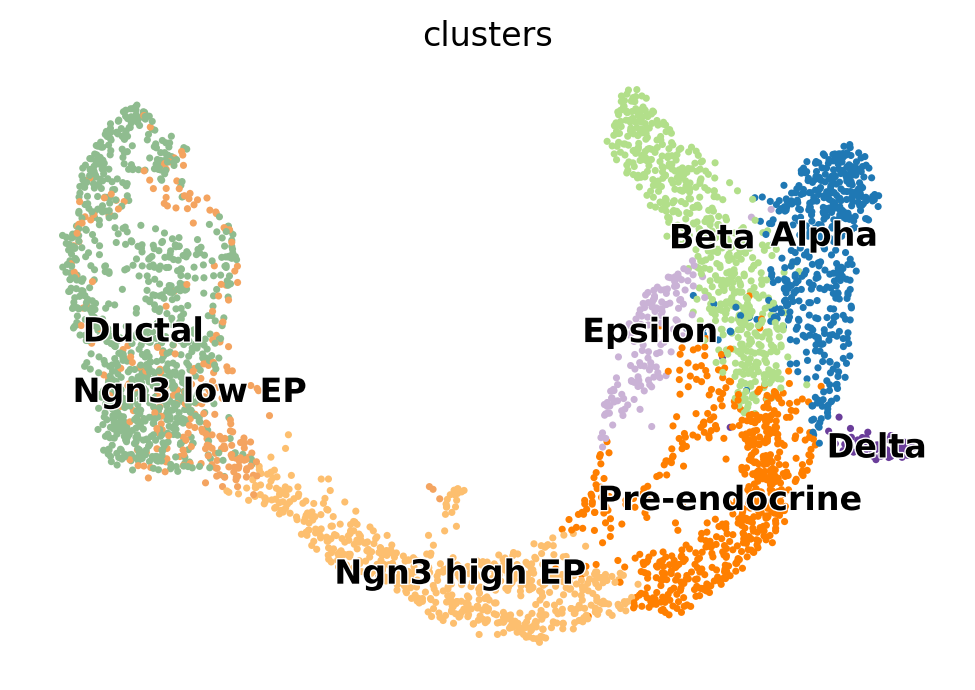

In [7]:
scv.pl.scatter(adata, basis="umap", color="clusters")

(trajectories-rna-velocity-key-takeaway-3)=
### RNA velocity inference - *Steady-state model*

As a first step, we calculate RNA velocity under the steady state model. In this case, we call *scVelo*'s `velocity` function with `mode="deterministic"`.

In [8]:
scv.tl.velocity(adata, mode="deterministic")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


While we do not encourage over interpreting projections of high-dimensional velocity vectors onto a low dimensional representation of the data, *scVelo* offers a simple way of doing so.

computing velocity graph (using 8/96 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


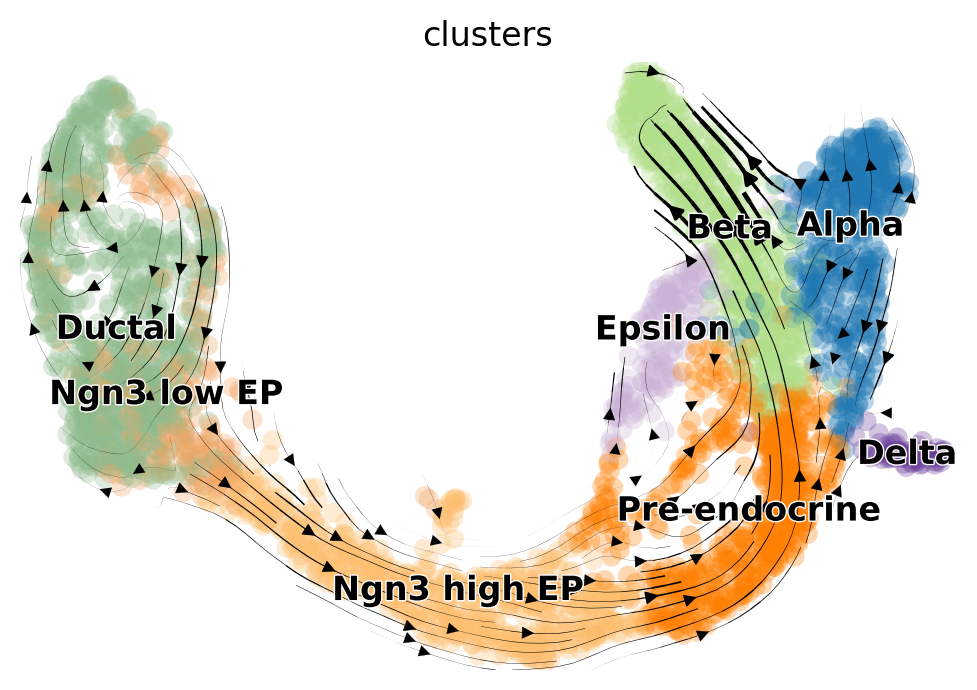

In [9]:
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(adata, basis="umap", color="clusters")

### RNA velocity inference - *EM model*

In order to calculate RNA velocity with the *EM model*, the parameters of splicing kinetics need to be inferred first. The inference is taken care of by *scVelo*'s `recover_dynamics` function.

In [10]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 8/96 cores)


  0%|          | 0/835 [00:00<?, ?gene/s]

    finished (0:01:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


The parameters of the splicing model are inferred by maximizing a given likelihood. To study which genes were fit most confidently by *scVelo*, we can study the corresponding phase portraits as well as the inferred trajectory (plotted in purple) and steady-state ratio (dashed purple line). Here, three out of the five shown genes (*Pcsk2*, *Top2a*, *Ppp1r1a*) exhibit phase portraits in a (partial) almond shape. We observe a clear transition either within a single cell type (*Top2a*, *Ppp1r1a*) or across several cell types (*Pcsk2*, from Pre-endocrine to Alpha and Beta). In the case of *Nfib*, we observe two cellular populations in steady state. This most likely an artifact of undersampling the phenotypic manifold around Ngn3 low/high EP cells. Similarly, *Ghrl* is highly expressed in Epsilon cells although only a few due to the small cluster size. While current best practices are limited to analysing model fits and the confidence therein by hand, recently proposed methods can help automate the process (New directions). Here, *Nfib* abd *Ghrl* would be assigned with a lower confidence score.

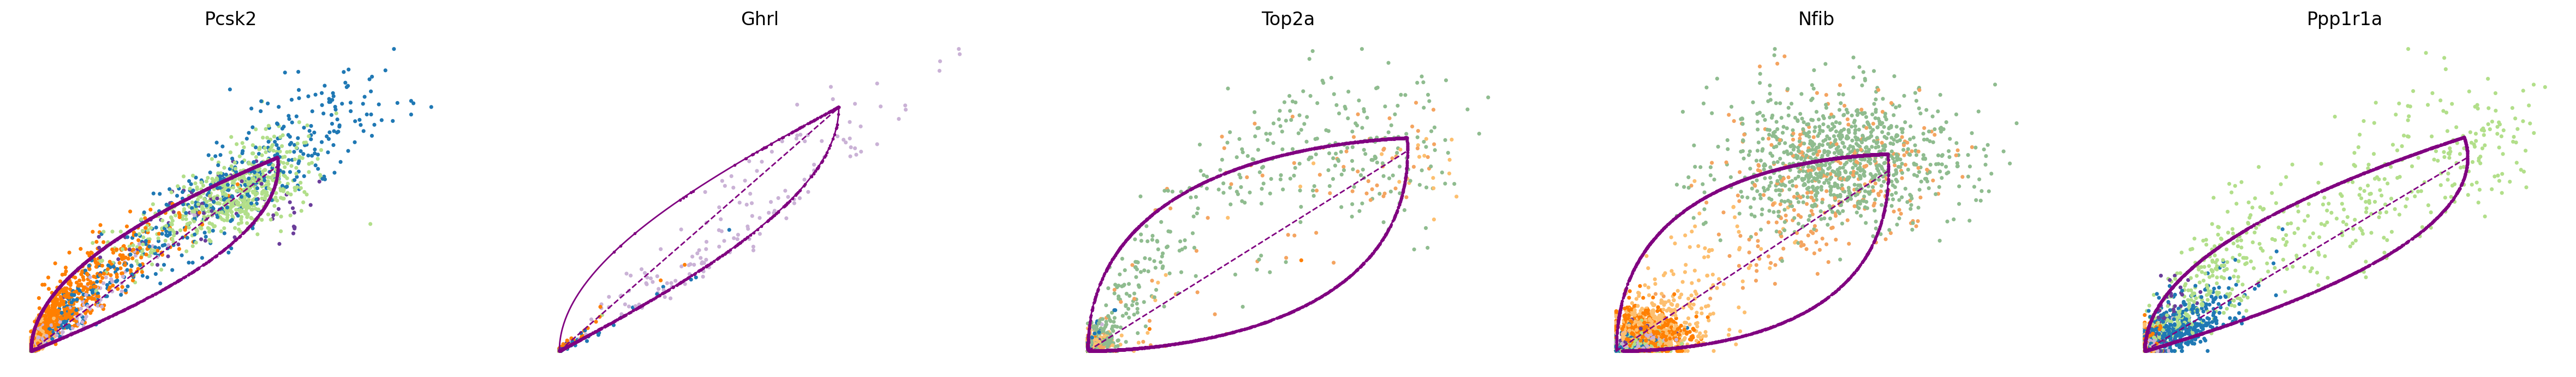

In [11]:
top_genes = adata.var["fit_likelihood"].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:5], color="clusters", frameon=False)

Having estimated the kinetics rates (stored as columns `fit_alpha`, `fit_beta`, `fit_gamma` of `adata.obs`), we can calculate both velocity and the projection onto our two-dimensional UMAP embedding.

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/96 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


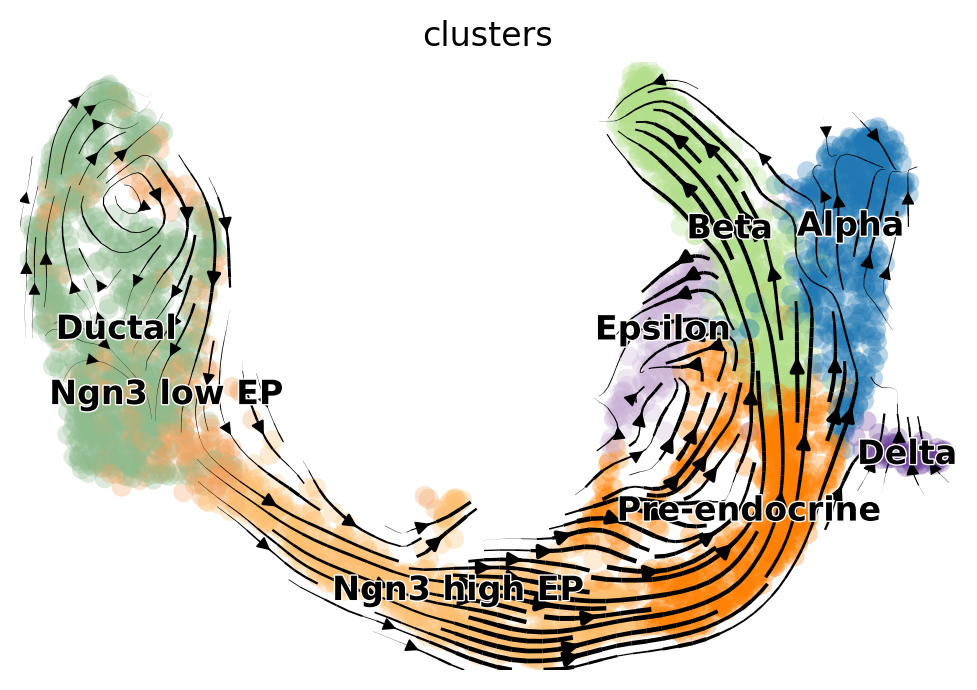

In [12]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(adata, basis="umap")

Based on the 2D projections, the *EM model* captures the cell cycle in the *Ductal* cells more faithfully. Additionally, the projection of the *steady-state model* exhibits a "backflow" from *Alpha*  to *Pre-endocrine* cells. However, for a rigorous and quantitative analysis, we recommend using downstream tools such as CellRank {cite}`velo:Lange2022` to assess model differences and draw conclusions.

## New directions

Although RNA velocity has been applied successfully to many systems, some model limitations persist. Violated model assumptions may cause erroneous result {cite}`velo:Bergen2021, velo:Barile2021`, and projecting the high dimensional velocity vectors onto a low dimensional representation of the data misleading. To overcome these pitfalls several tools have been developed. CellRank {cite}`velo:Lange2022`, for example, uses the inferred velocity field to infer likely future states of a cell. As the algorithm operates on the higher dimensional representation of the data, misleading velocity streams on embeddings are circumvented. Contrastingly, a recent publication tries to improve the quality of the lower dimensional embedding {cite}`velo:MarotLassauzaie2022`.

To soften current assumptions of RNA velocity inference, several new approaches have been suggested {cite}`velo:Qiao2021, velo:MarotLassauzaie2022, velo:Chen2022, velo:Riba2022, velo:Gu2022, velo:Gu2022-PLMR`, {cite}`velo:Gayoso2022`. For example, these methods try to no longer assume constant rates {cite}`velo:Chen2022, velo:Gu2022-PLMR`, work with raw counts {cite}`velo:Gu2022-PLMR`, or reformulate the inference methods in a variational inference framework to associate uncertainty with estimates {cite}`velo:Gayoso2022`. Additionally, to aid in understanding if RNA velocity analysis can be inferred for individual genes or entire datasets, different procedures have been proposed {cite}`velo:Zheng2022, velo:Gayoso2022`.

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: velo
```